In [33]:
import random
import json
import pickle

import numpy
import numpy as np
import tensorflow as tf

import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmetizer = WordNetLemmatizer()
intents = json.loads(open('intents_larger.json').read())
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '', ',']

nltk.data.find('tokenizers/punkt')
print("Punkt is installed correctly!")

Punkt is installed correctly!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tomas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tomas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        pattern_list = nltk.word_tokenize(pattern)
        words.extend(pattern_list)
        documents.append((pattern_list, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

classes = sorted(set(classes))

words = [lemmetizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))

pickle.dump(classes, open('classes.pkl', 'wb'))
pickle.dump(words, open('words.pkl', 'wb'))

documents

[(['Hi', 'there'], 'greeting'),
 (['How', 'are', 'you'], 'greeting'),
 (['Is', 'anyone', 'there', '?'], 'greeting'),
 (['Hey'], 'greeting'),
 (['Hola'], 'greeting'),
 (['Hello'], 'greeting'),
 (['Good', 'day'], 'greeting'),
 (['What', "'s", 'up', '?'], 'greeting'),
 (['Yo', '!'], 'greeting'),
 (['Hi', '!'], 'greeting'),
 (['Hey', 'there', '!'], 'greeting'),
 (['Howdy'], 'greeting'),
 (['Bye'], 'goodbye'),
 (['See', 'you', 'later'], 'goodbye'),
 (['Goodbye'], 'goodbye'),
 (['Nice', 'chatting', 'to', 'you', ',', 'bye'], 'goodbye'),
 (['Till', 'next', 'time'], 'goodbye'),
 (['See', 'ya', '!'], 'goodbye'),
 (['Catch', 'you', 'later', '!'], 'goodbye'),
 (['I', "'m", 'out'], 'goodbye'),
 (['Later', '!'], 'goodbye'),
 (['Take', 'care'], 'goodbye'),
 (['Thanks'], 'thanks'),
 (['Thank', 'you'], 'thanks'),
 (['That', "'s", 'helpful'], 'thanks'),
 (['Awesome', ',', 'thanks'], 'thanks'),
 (['Thanks', 'for', 'helping', 'me'], 'thanks'),
 (['I', 'appreciate', 'it'], 'thanks'),
 (['Many', 'thanks'], 

In [35]:
training_list = []
output_list = [0] * len(classes)

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [lemmetizer.lemmatize(word.lower()) for word in word_patterns]

    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_list)
    output_row[classes.index(document[1])] = 1

    training_list.append(bag + output_row)

random.shuffle(training_list)
training_list = np.array(training_list)

training_list.shape

(56, 98)

In [36]:
from keras.regularizers  import l2
from keras.optimizers import Adam
import keras
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import h5py

trainX = training_list[:, :len(words)]
trainY = training_list[:, len(words):]

model = keras.Sequential()
model.add(Dense(128, activation='relu', input_shape=(len(trainX[0]),), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(trainY[0]), activation='softmax'))

optimizer = Adam(learning_rate=0.0003)
cp = ModelCheckpoint('chatbot_model.keras', save_best_only=True, save_weights_only=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(
    np.array(trainX), np.array(trainY),
    epochs=200, batch_size=16, verbose=1,
    callbacks=[cp, early_stopping], validation_split=0.2
)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.2393 - loss: 4.0814 - val_accuracy: 0.0833 - val_loss: 4.0752
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2074 - loss: 4.0421 - val_accuracy: 0.0000e+00 - val_loss: 4.0551
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2429 - loss: 3.9836 - val_accuracy: 0.0000e+00 - val_loss: 4.0360
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1847 - loss: 4.0227 - val_accuracy: 0.0000e+00 - val_loss: 4.0182
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2195 - loss: 3.9725 - val_accuracy: 0.0000e+00 - val_loss: 4.0007
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2308 - loss: 3.9479 - val_accuracy: 0.0000e+00 - val_loss: 3.9834
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2038 - loss: 3.9277 - val_accuracy: 0.0000e+00 - val_loss: 3.9665
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2543 - loss: 3.9087 - val_accu

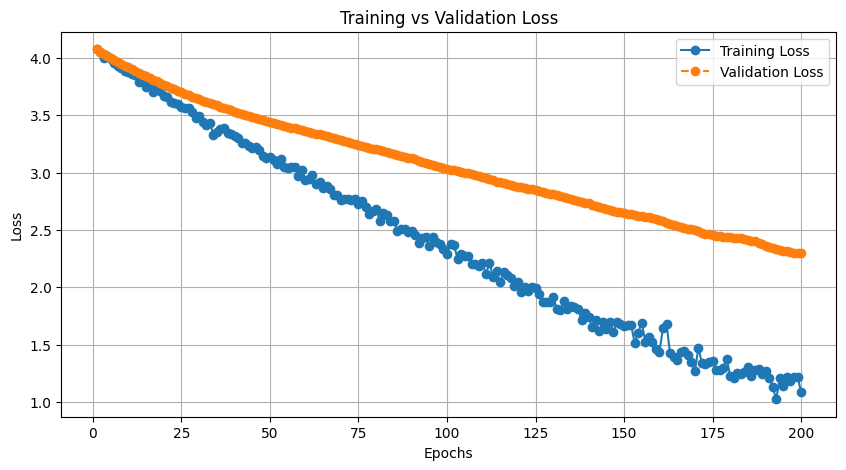

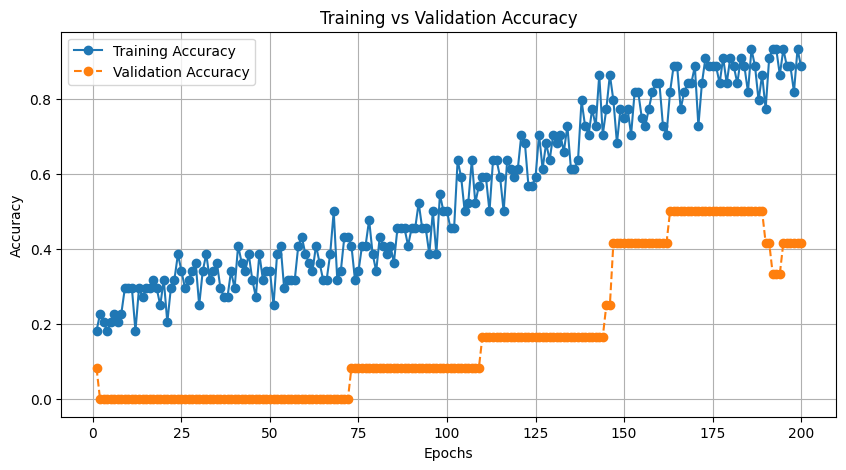

In [37]:
import matplotlib.pyplot as plt

def plot_training_results(history):

    epochs = range(1, len(history.history["loss"]) + 1)
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Training Loss", marker="o")
    plt.plot(epochs, val_loss, label="Validation Loss", marker="o", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training vs Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label="Training Accuracy", marker="o")
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_results(history)
